In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.layers import Dropout
from keras.models import Model

In [28]:
!pip list

Package                            Version
---------------------------------- --------------------
-illow                             8.2.0
-pencv-contrib-python              4.5.4.60
-tatsmodels                        0.12.2
absl-py                            1.1.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
awscli                             1.25.12
Babel                            

In [2]:
import zipfile
local_zip = './dataset.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
Lok = '/tmp/dataset/'

In [4]:
os.listdir('/tmp/dataset/')

['test', 'train']

# 2. Image Acquistion

In [5]:
kelas = []
n_gmbar = []
data = {'KualitasDaging':[], 'JumlahFoto':[]}

for i in os.listdir(Lok+'/train'):
    n_gmbar.append(len(os.listdir(Lok+'/train/'+i)))
    kelas.append(i)
    
data['KualitasDaging']+=kelas
data['JumlahFoto']+=n_gmbar

df = pd.DataFrame(data)
df

,KualitasDaging,JumlahFoto
0,AyamSegar,130
1,AyamTiren,200


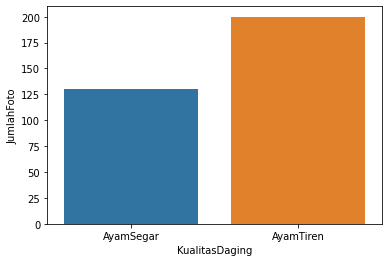

In [6]:
sns.barplot(x=df['KualitasDaging'], y=df['JumlahFoto'])

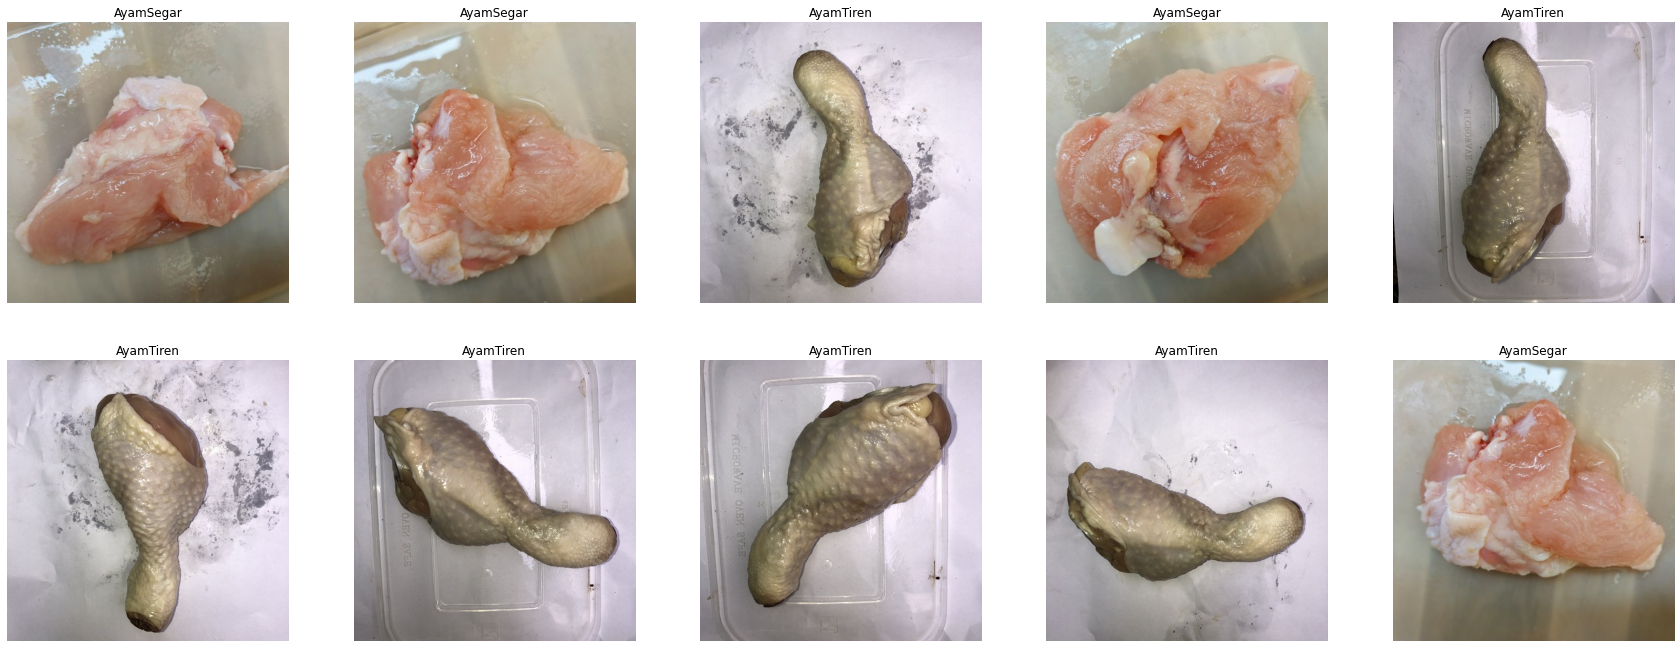

In [7]:
KualitasDaging = os.listdir(Lok+'/train')

plt.figure(figsize=(30,30))
for x in range(10):
    i       = random.randint(0,1)  #mengambbil gambar dari 3 folder
    NamaKls = os.listdir(Lok+'/train'+'/'+KualitasDaging[i])
    
    j          = random.randint(0,100)
    gmbr       = cv2.imread(Lok+'/train'+'/'+KualitasDaging[i]+'/'+NamaKls[j])
    gmbr       = cv2.cvtColor(gmbr, cv2.COLOR_BGR2RGB)
    ax         = plt.subplot(5, 5, x+1)
    plt.imshow(gmbr)
    plt.title(KualitasDaging[i])
    plt.axis("off")
    
plt.show()

# 3. Pre-processing

In [8]:
image_datagen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, 
                                                               rotation_range=20,
                                                              width_shift_range=0.2,
                                                              height_shift_range=0.2,
                                                              horizontal_flip=True,
                                                              validation_split=0.2)

In [9]:
train_ds = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='training',
                                            target_size=(150, 150),
                                            batch_size=10)

val_ds   = image_datagen.flow_from_directory(Lok+'/train',
                                            subset='validation',
                                            target_size=(150, 150),
                                            batch_size=10) 

Found 264 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


# 4. Modeling

## 4.1 Model InceptionV3

In [10]:
from tensorflow.keras.applications import InceptionV3


ModelInceptionV3 = tf.keras.models.Sequential([
    tf.keras.applications.InceptionV3(input_shape=(150, 150, 3),
                                         include_top=False,
                                         pooling='max',
                                         weights='imagenet'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(256, activation='ReLU'),
    tf.keras.layers.Dense(128, activation='ReLU'),
#     tf.keras.layers.Dense(64, activation='ReLU'),
#     tf.keras.layers.Dense(32, activation='ReLU'),
    tf.keras.layers.Dense(8, activation='ReLU'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2, activation='softmax')
])

In [11]:
ModelInceptionV3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,
                                                momentum=0.9
                                                 ), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

ModelInceptionV3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
Total params: 22,066,106
Trainable params: 22,031,674
No

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
CegahUnderOrOver = EarlyStopping(monitor='val_accuracy',
                                patience=10,
                                min_delta=0.001,
                                mode='max',
                                restore_best_weights=True
                                )

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                            factor=0.3,
                            patience=8,
                            min_lr=0.001,
                            mode='auto',
                            verbose=1)

In [14]:
%%time
train_InceptionV3 = ModelInceptionV3.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/12
27/27 [==============================] - 27s 808ms/step - loss: 0.7351 - accuracy: 0.6326 - val_loss: 0.2985 - val_accuracy: 0.8788 - lr: 1.0000e-04
Epoch 2/12
27/27 [==============================] - 22s 817ms/step - loss: 0.2997 - accuracy: 0.8485 - val_loss: 0.1204 - val_accuracy: 0.9545 - lr: 1.0000e-04
Epoch 3/12
27/27 [==============================] - 22s 831ms/step - loss: 0.1761 - accuracy: 0.9470 - val_loss: 0.1837 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 4/12
27/27 [==============================] - 24s 889ms/step - loss: 0.1991 - accuracy: 0.9356 - val_loss: 0.1243 - val_accuracy: 0.9697 - lr: 1.0000e-04
Epoch 5/12
27/27 [==============================] - 23s 833ms/step - loss: 0.1106 - accuracy: 0.9583 - val_loss: 0.2092 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 6/12
27/27 [==============================] - 23s 851ms/step - loss: 0.1088 - accuracy: 0.9545 - val_loss: 0.1571 - val_accuracy: 0.9697 - lr: 1.0000e-04
Epoch 7/12
27/27 [======================

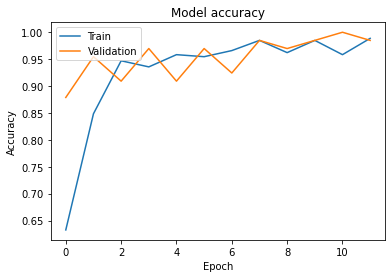

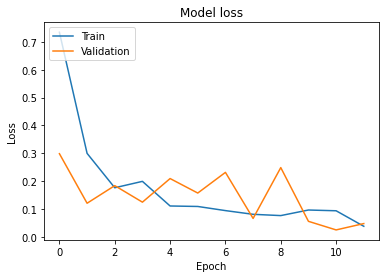

In [15]:
plt.plot(train_InceptionV3.history['accuracy'])
plt.plot(train_InceptionV3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_InceptionV3.history['loss'])
plt.plot(train_InceptionV3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 4.2 Model DenseNet201

In [16]:
ModelDenseNet201 = tf.keras.models.Sequential([
    tf.keras.applications.DenseNet201(input_shape=(150, 150, 3),
                                         include_top=False,
                                         pooling='max',
                                         weights='imagenet'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='ReLU'),
    tf.keras.layers.Dense(128, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='ReLU'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2, activation='softmax')
])

In [17]:
ModelDenseNet201.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005,
                                                momentum=0.9
                                                 ), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

ModelDenseNet201.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               491776    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [18]:
%%time
train_DenseNet201 = ModelDenseNet201.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/12
27/27 [==============================] - 84s 3s/step - loss: 0.4939 - accuracy: 0.7917 - val_loss: 0.1370 - val_accuracy: 0.9545 - lr: 5.0000e-04
Epoch 2/12
27/27 [==============================] - 68s 3s/step - loss: 0.0673 - accuracy: 0.9697 - val_loss: 0.0123 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 3/12
27/27 [==============================] - 66s 2s/step - loss: 0.1110 - accuracy: 0.9583 - val_loss: 0.0038 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 4/12
27/27 [==============================] - 70s 3s/step - loss: 0.0918 - accuracy: 0.9659 - val_loss: 0.0028 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 5/12
27/27 [==============================] - 73s 3s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 6/12
27/27 [==============================] - 67s 2s/step - loss: 0.0084 - accuracy: 0.9962 - val_loss: 0.0021 - val_accuracy: 1.0000 - lr: 5.0000e-04
Epoch 7/12
27/27 [==============================] - 69s 3s

## 4.3 Modeling VGG16

In [19]:
from tensorflow.keras.applications import VGG16

ModelVGG16 = tf.keras.models.Sequential([
    tf.keras.applications.VGG16(input_shape=(150, 150, 3),
                                         include_top=False,
                                         pooling='max',
                                         weights='imagenet'),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='ReLU'),
    tf.keras.layers.Dense(128, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='ReLU'),
    tf.keras.layers.Dense(32, activation='ReLU'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='ReLU'),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2, activation='softmax')
])

In [20]:
ModelVGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,
                                                momentum=0.9
                                                 ), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

ModelVGG16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)               

In [21]:
%%time
train_VGG16 = ModelVGG16.fit(train_ds, validation_data=val_ds, epochs=12, callbacks=[CegahUnderOrOver, reducelr])

Epoch 1/12
27/27 [==============================] - 77s 3s/step - loss: 0.7348 - accuracy: 0.4659 - val_loss: 0.6577 - val_accuracy: 0.7576 - lr: 1.0000e-04
Epoch 2/12
27/27 [==============================] - 79s 3s/step - loss: 0.6473 - accuracy: 0.6742 - val_loss: 0.6191 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/12
27/27 [==============================] - 87s 3s/step - loss: 0.6059 - accuracy: 0.7652 - val_loss: 0.5507 - val_accuracy: 0.9697 - lr: 1.0000e-04
Epoch 4/12
27/27 [==============================] - 85s 3s/step - loss: 0.5032 - accuracy: 0.8750 - val_loss: 0.3945 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/12
27/27 [==============================] - 94s 3s/step - loss: 0.3000 - accuracy: 0.9545 - val_loss: 0.1280 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/12
27/27 [==============================] - 84s 3s/step - loss: 0.1223 - accuracy: 0.9697 - val_loss: 0.0210 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/12
27/27 [==============================] - 83s 3s

# 5. Evaluasi Model

7/7 [==============================] - 4s 630ms/step - loss: 0.0015 - accuracy: 1.0000


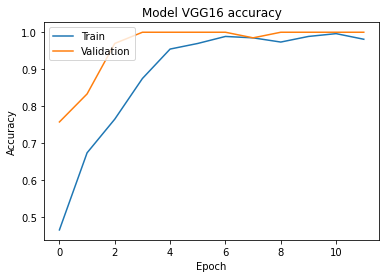

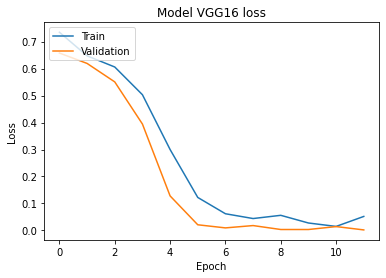

In [22]:
ModelVGG16.evaluate(val_ds)

plt.plot(train_VGG16.history['accuracy'])
plt.plot(train_VGG16.history['val_accuracy'])
plt.title('Model VGG16 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_VGG16.history['loss'])
plt.plot(train_VGG16.history['val_loss'])
plt.title('Model VGG16 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7/7 [==============================] - 3s 481ms/step - loss: 0.0183 - accuracy: 1.0000


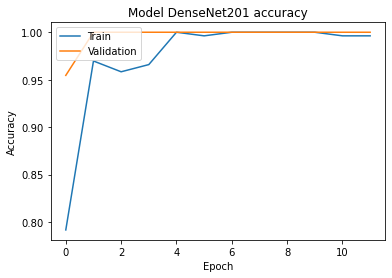

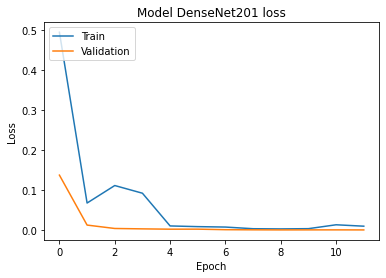

In [23]:
ModelDenseNet201.evaluate(val_ds)

plt.plot(train_DenseNet201.history['accuracy'])
plt.plot(train_DenseNet201.history['val_accuracy'])
plt.title('Model DenseNet201 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_DenseNet201.history['loss'])
plt.plot(train_DenseNet201.history['val_loss'])
plt.title('Model DenseNet201 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

7/7 [==============================] - 1s 121ms/step - loss: 0.1310 - accuracy: 0.9697


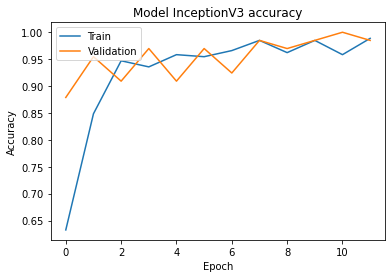

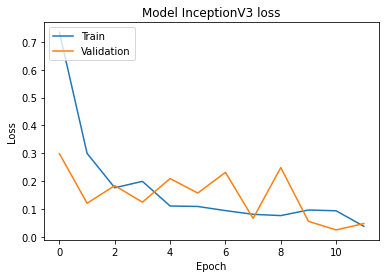

In [26]:
ModelInceptionV3.evaluate(val_ds)

plt.plot(train_InceptionV3.history['accuracy'])
plt.plot(train_InceptionV3.history['val_accuracy'])
plt.title('Model InceptionV3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(train_InceptionV3.history['loss'])
plt.plot(train_InceptionV3.history['val_loss'])
plt.title('Model InceptionV3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Simpan Model**

In [27]:
ModelDenseNet201.save("AyamDenseNet201-DanielMrnth.h5")
ModelVGG16.save("Ayam-VGG16-DanielMrnth.h5")
ModelInceptionV3.save("Ayam-InceptionV3-DanielMrnth.h5")

## Prediksi gambar gunakan GoogleColab

In [ ]:
import matplotlib.image as mpimg
import numpy as np
from io import BytesIO
from IPython.display import Image as IMG
import files
from keras.preprocessing import image
from shutil import copyfile

In [ ]:
def PredGambar(file_gmbr, model = ModelDenseNet201):
  file = file_gmbr
  gmbr_array = np.asarray(file)
  gmbr_array = gmbr_array*(1/225)
  gmbr_input = tf.reshape(gmbr_array, shape = [1, 150, 150, 3])

  predik_array = model.predict(gmbr_input)[0]

  df = pd.DataFrame(predik_array)
  df = df.rename({0:'NilaiKemiripan'}, axis = 'columns')
  Kualitas = ['AyamSegar', 'AyamTiren']
  df['Kelas'] = Kualitas
  df = df[['Kelas', 'NilaiKemiripan']]

  predik_kelas = np.argmax(model.predict(gmbr_input))

  if predik_kelas == 0:
    predik_Kualitas = 'AyamSegar'
  else:
    predik_Kualitas = 'AyamTiren'

  return predik_Kualitas, df
    

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array




UnggahFile = files.upload()

for n in UnggahFile.keys():
  lok = n
  gmbr = keras.utils.load_img(lok, target_size=(150,150))
  gmbrPlot = plt.imshow(gmbr)
  x = keras.utils.img_to_array(gmbr)
  x = np.expand_dims(x, axis=0)
  gmbr = np.vstack([x])

  kelas, df = PredGambar(gmbr)

  print('\n')
  plt.show()
  print("\nGambar dikenali sebagai " + kelas)
  print('\n')
  print(df)
  print('\n')

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array




UFile = files.upload()

for n in UFile.keys():
  lok = n
  gmbr = keras.utils.load_img(lok, target_size=(150,150))
  gmbrPlot = plt.imshow(gmbr)
  x = keras.utils.img_to_array(gmbr)
  x = np.expand_dims(x, axis=0)
  gmbr = np.vstack([x])

  kelas, df = PredGambar(gmbr)

  print('\n')
  plt.show()
  print("\nGambar dikenali sebagai " + kelas)
  print('\n')
  print(df)
  print('\n')

In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array




UngFile = files.upload()

for n in UngFile.keys():
  lok = n
  gmbr = keras.utils.load_img(lok, target_size=(150,150))
  gmbrPlot = plt.imshow(gmbr)
  x = keras.utils.img_to_array(gmbr)
  x = np.expand_dims(x, axis=0)
  gmbr = np.vstack([x])

  kelas, df = PredGambar(gmbr)

  print('\n')
  plt.show()
  print("\nGambar dikenali sebagai " + kelas)
  print('\n')
  print(df)
  print('\n')